# Defenses 

In [215]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from Net import Net , NetF1
from Attacks.LBFGS import LBFGSAttack
from Attacks.FGSM import FGSMAttack
from Attacks.VanillaGradient import VanillaGradientAttack

from defense import fit_distilled, test_vanilla_binary_mnist , test_fgsm_mnist_binary, adversarial_fit_normal, fit
from attack import test_fgsm_mnist, test_fgsm_mnist_distilled, test_vanilla_mnist
from utils import * 

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [214]:
mnist_trainset = datasets.MNIST('./data_mnist', 
                   train=True,
                   download=False, 
                   transform=transforms.Compose([transforms.ToTensor()]))

mnist_testset = datasets.MNIST('./data_mnist', 
                   train=False,
                   download=False, 
                   transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=32,shuffle=True)
train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=32,shuffle=True)


In [22]:
# Init device 
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Init the network
model = Net().to(device)

# Load pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [240]:
############ Training base model ############

#base_model = Net().to(device)
#optimizer = optim.Adam(base_model.parameters(),lr=0.0001, betas=(0.9, 0.999))
#criterion = F.cross_entropy
#
#loss = fit(base_model, 
#           device, 
#           criterion,
#           optimizer, 
#           train_loader,
#           test_loader,
#           epochs=10)

# Training a base model

In [232]:
pretrained_base_model = "weights/base_training.pt"
# Init the network
base_model = Net().to(device)

# Load pretrained model
base_model.load_state_dict(torch.load(pretrained_base_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
base_model.eval()
acc = validation(base_model,test_loader,device)

print('Base model accuracy : ', acc)

Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Base model accuracy :  0.9745


# Defense 1 : Binary threshold

The main idea is to get rid of the noise in the image before infering the class. This would take care of the adversarial exemple by denoising the added change to the input.

### Binary defense against Vanilla Attack

In [42]:
accuracies_vanilla_binary = []
examples_vanilla_binary = []
lmds =[0.01,0.1, 0.5,1]

# Run test for each lambda
for lmd in lmds:
    acc, ex = test_vanilla_binary_mnist(model, device, test_loader, lmd)
    accuracies_vanilla_binary.append(acc)
    examples_vanilla_binary.append(ex)

Lambda = 0.01:   0%|          | 0/313 [00:00<?, ?it/s]

Binary defense, Lambda 0.01 Accuracy: 0.1775 


Lambda = 0.1:   0%|          | 0/313 [00:00<?, ?it/s]

Binary defense, Lambda 0.1 Accuracy: 0.9773 


Lambda = 0.5:   0%|          | 0/313 [00:00<?, ?it/s]

Binary defense, Lambda 0.5 Accuracy: 0.9778 


Lambda = 1:   0%|          | 0/313 [00:00<?, ?it/s]

Binary defense, Lambda 1 Accuracy: 0.978 


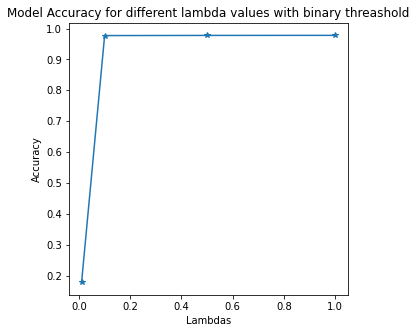

In [46]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(lmds, accuracies_vanilla_binary, "*-")
plt.title("Model Accuracy for different lambda values with binary threashold")
plt.xlabel("Lambdas")
plt.ylabel("Accuracy")
plt.savefig('Results/Testing Vanilla mnist binary.png')
plt.show()

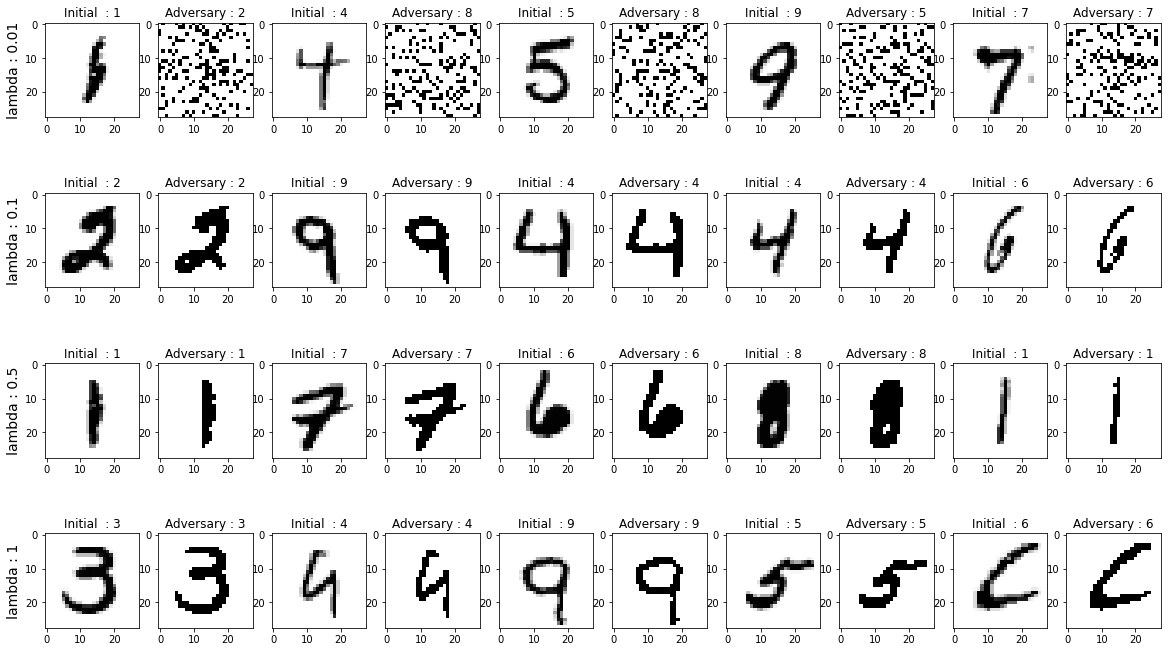

In [58]:
fig , axs = plt.subplots(nrows=len(lmds), ncols=len(examples_vanilla_binary[0])*2,figsize=(20,12))

for i , lmd in enumerate(lmds):
    for j in range(0,len(examples_vanilla_binary[0])):
        original, adversary, init_pred , final_pred = examples_vanilla_binary[i][j]
        axs[i, 2*j].imshow(original[0],cmap='Greys')
        axs[i,0].set_ylabel("lambda : {}".format(lmd), fontsize=14)
        axs[i, 2*j].set_title('Initial  : {}'.format(init_pred[0].item()))
        axs[i, 2*j+1].imshow(adversary[0],cmap='Greys')
        axs[i, 2*j+1].set_title('Adversary : {}'.format(final_pred[0].item()))
plt.savefig('Results/Exemples LBFGS mnist binary.png')
plt.show()

### Binary defense against FGSM

In [69]:
#%timeit 
accuracies_FGSM_binary = []
examples_FGSM_binary = []
epsilons =[0.1,0.3,0.5,0.7]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test_fgsm_mnist_binary(model, device, test_loader, eps)
    accuracies_FGSM_binary.append(acc)
    examples_FGSM_binary.append(ex)

Iteration for epsilon = 0.1:   0%|          | 0/10000 [00:00<?, ?it/s]

Binary defense, Epsilon 0.1 Accuracy: 0.956 


Iteration for epsilon = 0.3:   0%|          | 0/10000 [00:00<?, ?it/s]

Binary defense, Epsilon 0.3 Accuracy: 0.8549 


Iteration for epsilon = 0.5:   0%|          | 0/10000 [00:00<?, ?it/s]

Binary defense, Epsilon 0.5 Accuracy: 0.0985 


Iteration for epsilon = 0.7:   0%|          | 0/10000 [00:00<?, ?it/s]

Binary defense, Epsilon 0.7 Accuracy: 0.0239 


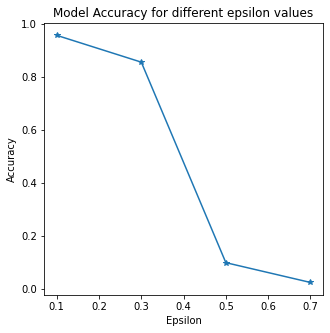

In [71]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(epsilons, accuracies_FGSM_binary, "*-")
plt.title("Model Accuracy for different epsilon values")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig('Results/Testing FGSM mnist binary.png')
plt.show()

--- 

# Defense 2 : Adversarial Training

This defense was proposed in Goodfellow et al., and is among the most popular ones. 
The idea is to add adversarial examples during the  training phase and
train the model either on adversarial examples or on mix of clean and adversarial
examples. 

The approach was successfully applied to large datasets and can be
made more effective by using discrete vector code representations rather than real
number representations of the input.


## Base model

We will start by training the base model to get an accurate mesure of the accuracy drop with FGSM attack. 

In [234]:
accuracies_FGSM = []
examples_FGSM = []
proba_FGSM = []

epsilons =[0.1,0.3,0.5,0.7]
model.eval()
# Run test for each epsilon
for eps in epsilons:
    acc, ex, proba_adv = test_fgsm_mnist(base_model, 
                                         device, 
                                         test_loader, 
                                         eps)
    accuracies_FGSM.append(acc)
    examples_FGSM.append(ex)
    proba_FGSM.append(proba_adv)

Iteration for epsilon = 0.1:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.1 Accuracy: 0.7551 


Iteration for epsilon = 0.3:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.3 Accuracy: 0.0205 


Iteration for epsilon = 0.5:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.5 Accuracy: 0.0016 


Iteration for epsilon = 0.7:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.7 Accuracy: 0.002 


We see a very big drop in accuracy after attacking the trained model once epsilon 0.3 .

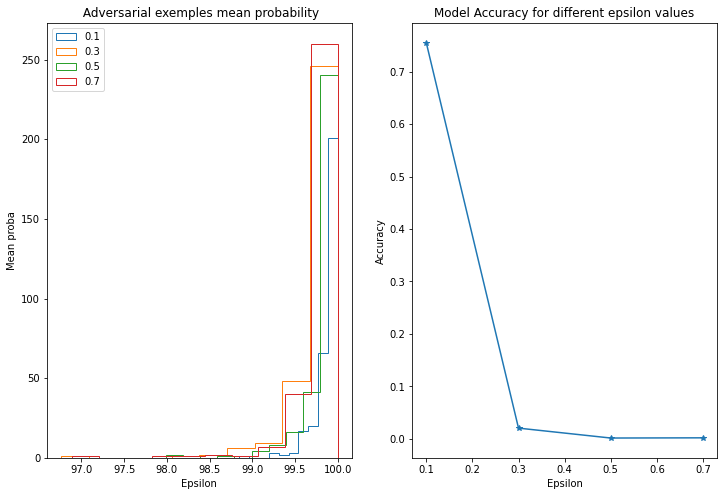

In [236]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
for i, _ in enumerate(epsilons):
    ax[0].hist(proba_FGSM[i],histtype='step', stacked=True, fill=False,label=_)
ax[0].legend()
#ax[0].plot(epsilons, proba_FGSM, "*-")
ax[0].set_title(" Adversarial exemples mean probability")
ax[0].set_xlabel("Epsilon")
ax[0].set_ylabel("Mean proba")


ax[1].plot(epsilons, accuracies_FGSM, "*-")
ax[1].set_title("Model Accuracy for different epsilon values")
ax[1].set_xlabel("Epsilon")
ax[1].set_ylabel("Accuracy")


plt.savefig('Results/FGSM_base_mnist.png')
plt.show()

## Adversarial training

In [112]:
#model = Net().to(device)
#optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
#model.train()

# Adversarial training function
# loss = adversarial_fit_normal(model, 
#                       device, 
#                       optimizer, 
#                       train_loader, 
#                       epochs=30)

We load the pretrained model. This model was trained on adversarial examples. This method of training is possible because the cost of generating them using FGSM attack is very low. We trained the model with an adversarial objective function based on the fast gradient sign method was an effective regularizer :

$$J(\theta,x,y) = \alpha J(\theta,x,y)  +(1-\alpha)J(\theta,x+ \epsilon*sign(\nabla_{x}J(\theta,x,y) ,y) $$ 

In [207]:
# Loading pretrained with adversarial training Net
pretrained_model = "weights/adv_training.pt"
model = Net().to(device)

#Load pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [209]:
accuracies_FGSM_trained = []
examples_FGSM_trained = []
proba_FGSM_trained = []

epsilons =[0.1,0.3,0.5,0.7]
model.eval()
# Run test for each epsilon
for eps in epsilons:
    acc, ex, proba_adv = test_fgsm_mnist(model, 
                                         device, 
                                         test_loader, 
                                         eps)
    accuracies_FGSM_trained.append(acc)
    examples_FGSM_trained.append(ex)
    proba_FGSM_trained.append(proba_adv)

Iteration for epsilon = 0.1:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.1 Accuracy: 0.9336 


Iteration for epsilon = 0.3:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.3 Accuracy: 0.7099 


Iteration for epsilon = 0.5:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.5 Accuracy: 0.1979 


Iteration for epsilon = 0.7:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.7 Accuracy: 0.0427 


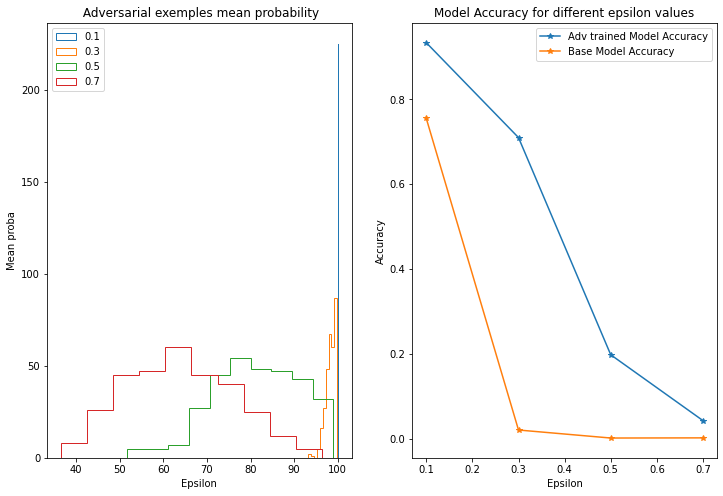

In [239]:
fig, ax = plt.subplots(1,2,figsize=(12,8))
for i, _ in enumerate(epsilons):
    ax[0].hist(proba_FGSM_trained[i],histtype='step', stacked=True, fill=False,label=_)
ax[0].legend()
#ax[0].plot(epsilons, proba_FGSM, "*-")
ax[0].set_title(" Adversarial exemples mean probability")
ax[0].set_xlabel("Epsilon")
ax[0].set_ylabel("Mean proba")


ax[1].plot(epsilons, accuracies_FGSM_trained, "*-",label='Adv trained Model Accuracy')
ax[1].set_title("Model Accuracy for different epsilon values")
ax[1].plot(epsilons, accuracies_FGSM, "*-",label='Base Model Accuracy')

ax[1].set_xlabel("Epsilon")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.savefig('Results/Testing FGSM defense mnist.png')
plt.show()

We clearly see that the model has become somewhat resistant to adversarial examples. The same model had an accuracy of 7% when being attacked with FGSM. The accuracy is now 70%. We also see that the trained model is not robust enough against higher perturbation but does assing a class with lower confidence. 

---- 
# Defense 3 : Distilled Neural Network

First strategy(distilled model):  see  Papernot, N., McDaniel, P., Wu, X., Jha, S., and Swami, A. Distillation as a defense to adversarial perturbations against deep neural networks. arXiv preprint arXiv:1511.04508, 2016b.
  1. Train a network F on the given training set (X,Y) by setting the temperature of the softmax to T.
  2. Compute the scores (after softmax) given by F(X) again and evaluate the scores at temperature T.
  3. Train another network F'_T using softmax at temperature T on the dataset with soft labels (X,F(X)). We refer the model F'_T as the distilled model.
Use the distilled network F'_T with softmax at temperature 1, which is denoted as F'1 during prediction on test data Xtest(or adversarial examples).
Taken Temperature as 100 for training the NetF and NetF'

The rough idea is that existing fast methods for finding adversarial examples (§II.B) rely on looking at the gradient and either adjusting all pixels by a small amount (Goodfellow 2015) or adjusting a small number of salient pixels a large amount (Papernot 2015a). This is most effective when the gradient is large. There are theoretical reasons to expect that distilling a network (more on what this is in a minute) will tend to reduce gradients, encouraging the output to be nearly flat close to training examples. The authors tested this against MNIST and CIFAR10 classifiers, showing strong reductions in the susceptibility to adversarial examples (from 95.89% to 0.45% and 87.89% to 5.11%, respectively), very little loss in accuracy, and increased robustness.
What’s this distillation thing? Originally intended to compress models to run on cheaper hardware, distillation (§II.C) involves a typically smaller network learning another network’s output function. But instead of predicting hard class labels (0 or 1), the distillation network instead predicts the class probabilities generated by the first network. The full probability distribution contains more information than a single label, so intuitively we should be able to take advantage of this. The authors give this example from MNIST: a training example that has high probability for both the 1 and 7 labels “indicates that 7s and 1s look similar and intuitively allows a model to learn the structural similarity between the two digits.” (Emphasis in original.) In this paper rather than compressing the distillation into a smaller network, they train a distillation network of the same size as the original.
There’s a further detail to distillation, which is that — during training — the softmax layer includes a temperature parameter T:

Here the z are the activations of the last layer before the softmax. T = 1 is equivalent to standard softmax. Increasing T has the effect of pushing the resulting probability distribution closer to uniform. At test time the temperature is set back to 1. There’s an argument in §IV.B that higher temperatures also tend to flatten out the Jacobian, which is the real motivation behind this approach. The authors used T = 20.
There are two other main lines of discussion in the paper. One is on a robustness metric (§III.A) for neural nets building on Fawzi 2015, defining the metric as the expected minimum distance to an adversarial example (the expectation is over points drawn from the distribution being modeled). Defensive distillation improved robustness by 7.9x and 5.6x for the networks tested, according to this metric.m

### Load teacher model

In [113]:
pretrained_teacher = "weights/teacher_model_weights_T_100"

In [114]:
# Init teacher Network
teacher_model = Net().to(device)

# Load pretrained model
teacher_model.load_state_dict(torch.load(pretrained_teacher, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
teacher_model.eval() # 92% acc on val set

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### Distilled NN  data

In [132]:
distilled_model= NetF1().to(device)

optimizer = optim.Adam(distilled_model.parameters(), lr=0.001, betas=(0.9, 0.999))

loss_distilled = fit_distilled(teacher_model,
                               distilled_model,
                               device, 
                                optimizer, 
                                train_loader,
                                test_loader,
                                epochs=10,
                                T=100)

Fitting the distilled model ...


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1 Loss: 1.177919700495402 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 Val accuracy: 0.8484 


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.4807998865922292 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 Val accuracy: 0.8823 


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.46536492331822715 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 Val accuracy: 0.886 


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.4626805235862732 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 Val accuracy: 0.8863 


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5 Loss: 0.4615880283991496 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 Val accuracy: 0.8887 


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6 Loss: 0.46121673736572266 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6 Val accuracy: 0.8883 


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7 Loss: 0.4609280939737956 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7 Val accuracy: 0.89 


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.46073610552152 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8 Val accuracy: 0.8906 


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9 Loss: 0.4605316662152608 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9 Val accuracy: 0.8897 


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10 Loss: 0.46031084864934285 


Accuracy for testset:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 10 Val accuracy: 0.8868 


## Why use temperature ? 

This is a strategy where we train the model to output probabilities of different classes, rather than hard decisions about which class to output. The probabilities are supplied by an earlier model(the teacher model), trained on the same task using hard class labels.

* Model distillation is a technique that learns a secondary model to mimic what a primary model has learned, by training on the primary model’s “soft” probability outputs, rather than the “hard” (0/1) true label.
* the secondary model is trained in a way that pushes it to produce a more even distribution over outputs, rather than one very confident value and many other vary small ones.

--- 

## Defense againt FGSM attack

In [199]:
accuracies_FGSM_distilled = []
examples_FGSM_distilled = []
epsilons =[0.01,0.1, 0.5,1]
proba_FGSM_distilled = []
# Run test for each lambda


for eps in epsilons:
    final_acc, adv_examples, proba_adv = test_fgsm_mnist(distilled_model, 
                                                         device, 
                                                         test_loader, 
                                                         epsilon = eps,  
                                                         T=100)
    accuracies_FGSM_distilled.append(final_acc)
    examples_FGSM_distilled.append(adv_examples)
    proba_FGSM_distilled.append(proba_adv)

Iteration for epsilon = 0.01:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.01 Accuracy: 0.8705 


Iteration for epsilon = 0.1:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.1 Accuracy: 0.8214 


Iteration for epsilon = 0.5:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 0.5 Accuracy: 0.8165 


Iteration for epsilon = 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epsilon 1 Accuracy: 0.8153 


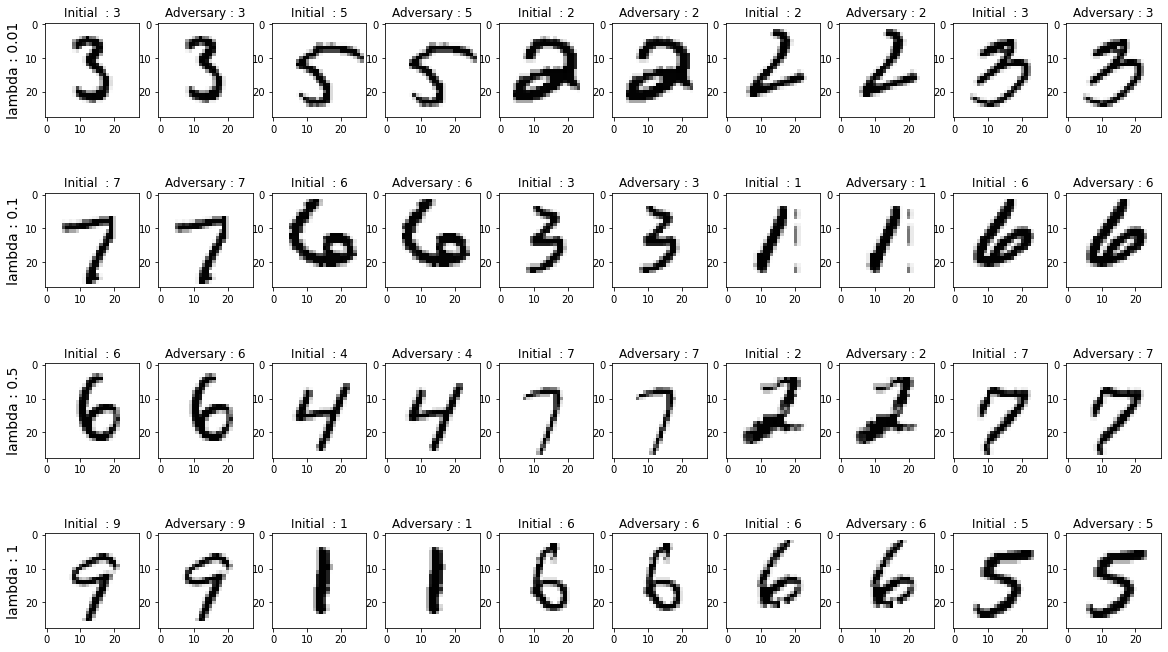

In [202]:
fig , axs = plt.subplots(nrows=len(lmds), ncols=len(examples_FGSM_distilled[0])*2,figsize=(20,12))

for i , lmd in enumerate(lmds):
    for j in range(0,len(examples_FGSM_distilled[0])):
        original, adversary, init_pred , final_pred = examples_FGSM_distilled[i][j]
        axs[i, 2*j].imshow(original[0],cmap='Greys')
        axs[i,0].set_ylabel("lambda : {}".format(lmd), fontsize=14)
        axs[i, 2*j].set_title('Initial  : {}'.format(init_pred[0].item()))
        axs[i, 2*j+1].imshow(adversary[0],cmap='Greys')
        axs[i, 2*j+1].set_title('Adversary : {}'.format(final_pred[0].item()))
plt.show()

Gradient masking works when training the distilled network. 

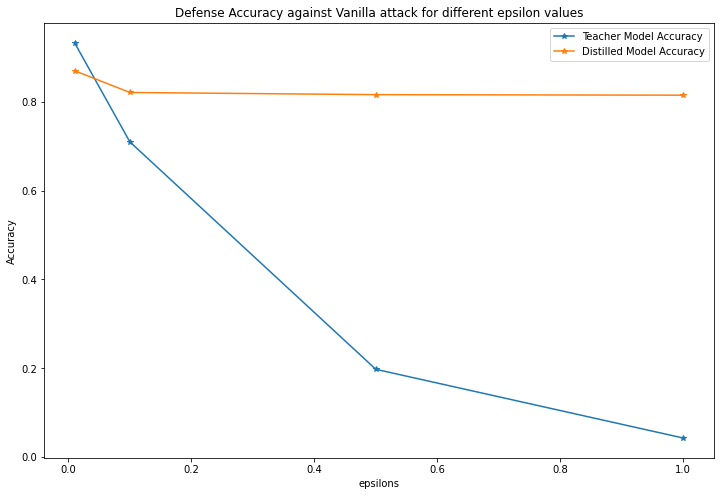

In [205]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(epsilons, accuracies_FGSM, "*-",label='Teacher Model Accuracy')
ax.plot(epsilons, accuracies_FGSM_distilled, "*-",label='Distilled Model Accuracy')
plt.title("Defense Accuracy against Vanilla attack for different epsilon values")
ax.legend()
plt.xlabel("epsilons")
plt.ylabel("Accuracy")

plt.savefig('Distilled model test accuracies')
plt.show()